# Exercise 1: Star/Quasar Classification with GMM

In the tutorial, we used a Gaussian Naive Bayes Classifier to separate Quasars
And Stars.  In this exercise, we will extend this classification scheme
using Gaussian Mixture Models.

The Gaussian Naive Bayes method works by computing a Gaussian approximation
to the distribution of each training class, and using these distributions
to predict the most probable label for any new point.

Here we're going to extend this, and rather than fitting a *single* Gaussian
to each label distribution, we're going to fit a *mixture* of Gaussians, which
should better approximate the distribution of each class of points.

First a brief backround on what Gaussian Naive Bayes is.
Suppose you have a dataset consisting of two clusters of points.
We'll generate them here:

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

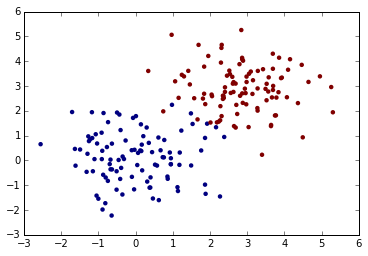

In [28]:
np.random.seed(0)
X = np.vstack([np.random.normal(0, 1, size=(100, 2)),
    np.random.normal(3, 1, size=(100, 2))])
y = np.zeros(200)
y[100:] = 1
plt.scatter(X[:, 0], X[:, 1], c=y, linewidth=0)

If you examine the source code of ``sklearn.naive_bayes.GaussianNB``,
you'll see that internally it finds a best-fit Gaussian for each
distribution, and uses these as a smooth description of each distribution.
We can use the internals of ``GaussianNB`` to visualize the distributions
it uses:

In [29]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X, y)

print(gnb.theta_) # centers of the distributions
print(gnb.sigma_) # widths of the distributions

[[ -9.57681805e-04   1.42778668e-01]
 [  2.85692167e+00   2.88704937e+00]]
[[ 1.04439794  1.03188094]
 [ 0.92864415  0.85037393]]


In [30]:
# create a grid on which to evaluate the distributions
grid = np.linspace(-3, 6, 100)
xgrid, ygrid = np.meshgrid(grid, grid)
Xgrid = np.vstack([xgrid.ravel(), ygrid.ravel()]).T
Xgrid

array([[-3.        , -3.        ],
       [-2.90909091, -3.        ],
       [-2.81818182, -3.        ],
       ..., 
       [ 5.81818182,  6.        ],
       [ 5.90909091,  6.        ],
       [ 6.        ,  6.        ]])

In [31]:
xgrid.ravel().shape

(10000,)

In [32]:
xgrid.shape

(100, 100)

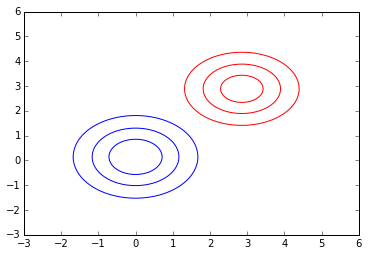

In [33]:
# now evaluate and plot the probability grid
prob_grid = np.exp(gnb._joint_log_likelihood(Xgrid))
for i, c in enumerate(['blue', 'red']):
    plt.contour(xgrid, ygrid, prob_grid[:, i].reshape((100, 100)), 3, colors=c)

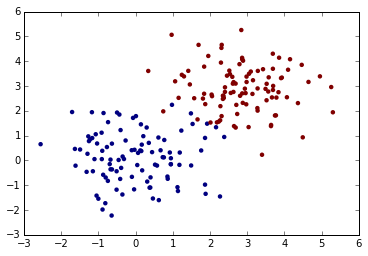

In [34]:
# plot the points as above
plt.scatter(X[:, 0], X[:, 1], c=y, linewidth=0)

When a new item is to be classified, its probability is evaluated
for each distribution, and the distribution with the highest
probability wins.  We can see now why this is called "naive".  What
if the distribution is not well-fit by an uncorrelated Gaussian?

In the following, we'll develop a classifier which solves this issue
by fitting a *sum* of gaussians to each distribution.  This should
lead to improved classifications.  For our data, we'll use photometric
observations of stars and quasars from the Sloan Digital Sky Survey.

## Loading Data


In [37]:
import os
DATA_HOME = os.path.abspath('data/sdss_colors')

In [38]:
import numpy as np
train_data = np.load(os.path.join(DATA_HOME,
                                  'sdssdr6_colors_class_train.npy'))
test_data = np.load(os.path.join(DATA_HOME,
                                 'sdssdr6_colors_class.200000.npy'))

###Setting up the data

In [39]:
# set the number of training points: using all points leads to a very
# long running time.  We'll start with 10000 training points.  This
# can be increased if desired.
Ntrain = 10000
#Ntrain = len(train_data)

In [40]:
# Split training data into training and cross-validation sets
np.random.seed(0)
np.random.shuffle(train_data)
train_data = train_data[:Ntrain]

N_crossval = Ntrain / 5
train_data = train_data[:-N_crossval]
crossval_data = train_data[-N_crossval:]

In [44]:
# construct training data
X_train = np.zeros((train_data.size, 4), dtype=float)
X_train[:, 0] = train_data['u-g']
X_train[:, 1] = train_data['g-r']
X_train[:, 2] = train_data['r-i']
X_train[:, 3] = train_data['i-z']
y_train = (train_data['redshift'] > 0).astype(int)
Ntrain = len(y_train)

In [46]:
# construct cross-validation data
X_crossval = np.zeros((crossval_data.size, 4), dtype=float)
X_crossval[:, 0] = crossval_data['u-g']
X_crossval[:, 1] = crossval_data['g-r']
X_crossval[:, 2] = crossval_data['r-i']
X_crossval[:, 3] = crossval_data['i-z']
y_crossval = (crossval_data['redshift'] > 0).astype(int)
Ncrossval = len(y_crossval)

(-1, 3)

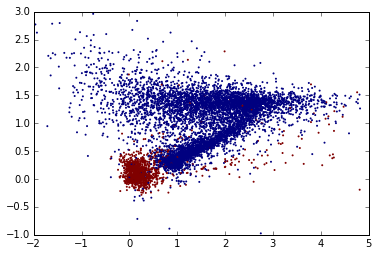

In [54]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=4, linewidths=0)
plt.xlim(-2,5)
plt.ylim(-1,3)

We have training distributions which are fairly well-separated.
Note, though, that these distributions are not well-approximated
by a single Gaussian!  Still, Gaussian Naive Bayes can be a
useful classifier.

## Exercise 1: Recreating Gaussian Naive Bayes

Gaussian Naive Bayes is a very fast estimator, and predicted labels can be computed as follows:

In [57]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_gnb = gnb.predict(X_crossval)
np.mean(y_gnb == y_crossval)

0.78600000000000003

### Part 1

Here we will use Gaussian Mixture Models to duplicate our Gaussian
Naive Bayes results from earlier.  You'll create two ``sklearn.gmm.GMM()``
classifier instances, named ``clf_0`` and ``clf_1``.  Each should be
initialized with a single component, and diagonal covariance.
(hint: look at the doc string for ``sklearn.gmm.GMM`` to see how to set
this up).  The results should be compared to Gaussian Naive Bayes
to check if they're correct.

In [58]:
from sklearn.mixture import gmm

In [60]:
clf_0 = gmm.GMM(n_components=1, covariance_type='diag')
clf_1 = gmm.GMM(n_components=1, covariance_type='diag')
clf_0.fit(X_train[y_train == 0])
clf_1.fit(X_train[y_train == 1])

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=1, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=0.01)

### Part 2

Next we must construct the prior.  The prior is the fraction of training
points of each type.

In [63]:
# variables to compute:
#  - prior0 : fraction of training points with y == 0
#  - prior1 : fraction of training points with y == 1

prior0 = np.mean(y_train == 0)         # short form method
prior1 = np.sum(y_train == 1)/Ntrain   # method 2
print(prior0, prior1)

0.848875 0.151125


###Part 3

Now we use the prior and the classifiation to compute the log-likelihoods
of the cross-validation points.  The log likelihood for a test point ``x``
is given by
   
     logL(x) = clf.score(x) + log(prior)

You can use the function ``np.log()`` to compute the logarithm of the prior.

In [69]:
#  variables to compute:
#    logL : array, shape = (2, Ncrossval)
#            logL[0] is the log-likelihood for y == 0
#            logL[1] is the log-likelihood for y == 1
logL = np.zeros([2,Ncrossval])
logL[0] = clf_0.score(X_crossval) + np.log(prior0)
logL[1] = clf_1.score(X_crossval) + np.log(prior1)
logL.shape

(2, 2000)

Once logL is computed, the predicted value for each sample is the index with the largest log-likelihood.

In [72]:
y_pred = np.argmax(logL, 0)
y_pred

array([0, 1, 1, ..., 1, 1, 0])

In [75]:
np.mean(y_pred == y_crossval)

0.78649999999999998

### Comparing to GNB

Now we compare our predicted labels to ``y_gnb``, the labels we
printed above.  We'll use the built-in classification
report function in sklearn.metrics.  This computes the precision,
recall, and f1-score for each class.

In [77]:
from sklearn import metrics

print ("-----------------------------------------------------")
print ("One-component Gaussian Mixture:")
print (metrics.classification_report(y_crossval, y_pred,
                                    target_names=['stars', 'QSOs']))

print ("-----------------------------------------------------")
print ("Gaussian Naive Bayes:")
print (metrics.classification_report(y_crossval, y_gnb,
                                    target_names=['stars', 'QSOs']))

-----------------------------------------------------
One-component Gaussian Mixture:
             precision    recall  f1-score   support

      stars       0.98      0.76      0.86      1681
       QSOs       0.42      0.91      0.58       319

avg / total       0.89      0.79      0.81      2000

-----------------------------------------------------
Gaussian Naive Bayes:
             precision    recall  f1-score   support

      stars       0.98      0.76      0.86      1681
       QSOs       0.42      0.91      0.57       319

avg / total       0.89      0.79      0.81      2000



In theory, the results of these two should be identical.  In reality, the
two algorithms approach the fits differently, leading to slightly different
results.  The precision, recall, and F1-score should match to within ~0.01.
If this is the case, then we can go on and experiment with a more complicated
model.

## Exercise 2: Parameter Optimization

Now we'll take some time to experiment with the *hyperparameters* of our
GMM Bayesian classifier.  These include the number of components for each
model and the covariance type for each model (i.e. parameters that are
decided prior to the fitting of the model on training data.

Note that for a large number of components, the fit can take a long
time, and will be dependent on the starting position.  Use the
documentation string of GMM to determine the options for covariance.

Note that there are tools within scikit-learn to perform hyperparameter
estimation, in the module ``sklearn.grid_search``.
Here we will be doing it by hand.

### Part 1

The first part of this exercise is to re-implement the GMM estimator above
in a single function which allows the number of clusters and covariance type
to be specified.  To follow the scikit-learn syntax, this should be a class
with methods like ``fit()``, ``predict()``, ``predict_proba()``, etc.
This would be an interesting project (and could even be a useful contribution
to scikit-learn!).  For now, we'll take a shortcut and just define a
stand-alone function.

In [78]:
# finish this function.  For n_components=1 and
# covariance_type='diag', it should give results
# identical to what we saw above.

# the function should return the predicted
# labels y_pred.
def GMMBayes(X_test, n_components, covariance_type):
    clf_0 = gmm.GMM(n_components, covariance_type, random_state=0)
    i0 = (y_train == 0)
    clf_0.fit(X_train[i0])

    clf_1 = gmm.GMM(n_components, covariance_type, random_state=0)
    i1 = (y_train == 1)
    clf_1.fit(X_train[i1])

    logL = np.zeros((2, X_test.shape[0]))
    logL[0] = clf_0.score(X_test) + np.log(prior0)
    logL[1] = clf_1.score(X_test) + np.log(prior1)

    y_pred = np.argmax(logL, 0)

    return y_pred

### Part 2

Now we'll apply this to our training data, and take a look at the F1-score
as a function of the hyperparameters.  Here is an example of computing the
F1-score for a particular choice of parameters:

In [80]:
n_components = 3
covariance_type = 'full'

y_pred = GMMBayes(X_train, n_components, 'full')
f1 = metrics.f1_score(y_train, y_pred)

print(f1)

0.908569085691


In [99]:
n_components = 30
covariance_type = 'full'

y_pred = GMMBayes(X_train, n_components, 'full')
f1 = metrics.f1_score(y_train, y_pred)

print(f1)

0.964970809008


In [96]:
gmm.GMM?

### Part 3

Once you have settled on a choice of hyperparameters, it's time to
evaluate the test data using this model.  First we'll construct the
test data as we did the training and cross-validation data above:

In [101]:
X_test = np.zeros((test_data.size, 4), dtype=float)
X_test[:, 0] = test_data['u-g']
X_test[:, 1] = test_data['g-r']
X_test[:, 2] = test_data['r-i']
X_test[:, 3] = test_data['i-z']
y_pred_literature = (test_data['label'] == 0).astype(int)
Ntest = len(y_pred_literature)

print (Ntest)

200000


Now follow the procedure above, and for the test data predict the labels using the Gaussian Naive Bayes estimator, as well as our Gaussian Mixture Bayes estimator. For simplicity, you may wish to use the Gaussian Mixture estimator to evaluate the Naive Bayes result.

In [103]:
# variables to compute:
#   y_pred_gmm : predicted labels for X_test from GMM Bayes model
#   y_pred_gnb : predicted labels for X_test with Naive Bayes model.
y_pred_gmm = GMMBayes(X_test, 5, 'full')
y_pred_gnb = gnb.predict(X_test)

In [105]:
print ("------------------------------------------------------------------")
print ("Comparison of current results with published results (Naive Bayes)")
print (metrics.classification_report(y_pred_literature, y_pred_gnb,
                                    target_names=['stars', 'QSOs']))

print ("------------------------------------------------------------------")
print ("Comparison of current results with published results (GMM Bayes)")
print (metrics.classification_report(y_pred_literature, y_pred_gmm,
                                    target_names=['stars', 'QSOs']))

------------------------------------------------------------------
Comparison of current results with published results (Naive Bayes)
             precision    recall  f1-score   support

      stars       0.99      0.60      0.75    186721
       QSOs       0.14      0.94      0.25     13279

avg / total       0.94      0.62      0.72    200000

------------------------------------------------------------------
Comparison of current results with published results (GMM Bayes)
             precision    recall  f1-score   support

      stars       0.99      0.98      0.99    186721
       QSOs       0.77      0.91      0.83     13279

avg / total       0.98      0.98      0.98    200000



If you're on the right track, you should find that the GMM-based
model has led to a classifier more consistent with the results
from the literature.
This is an example where the Naive Bayes model was too simple: it
under-fit the data, and thus increasing the model complexity has
led to a better classification algorithm.